In [11]:
##############
##### This is DEPRECATED
#############

import pickle
import gzip
import pandapower as pp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
module_path = os.path.abspath(os.path.join('..',os.pardir))
if module_path not in sys.path:
    sys.path.append(os.path.join(module_path,"src"))

import prepare_data
from commons import DATA_PROCESSED_DIR, DATA_RAW_DIR, RES_DATA_DIR
from os.path import join, isfile
import logging
from commons import Methods
sns.set_theme()
sns.set_style("darkgrid")





car0_path = "data\car\ZLE_freetime_W53_fdf22_Volkswagen_ID.3_2020_8fa92_avai_a7741.pickle"
car1_path = "data\car\ZLE_fulltime_W53_75853_Renault_Zoe_Q90_2019_9e477_avai_53e02.pickle"
car2_path = "data\car\ZLE_fulltime_W53_75853_Tesla_Model_3_Long_Range_AWD_2019_15218_avai_597fd.pickle"
paths = [car0_path, car1_path, car2_path]


In [8]:

from commons import DATA_CAR_DIR
DATA_CAR_DIR

'd:\\GitHubRepos\\development-of-a-grid-monitor'

# Prepare the data
Make sure to run the functions in the different files

* prepare_create_electric_grid.create_grid()
* prepare_houseloads_data.create_household_data(houses=49,units_per_house=6,year=2020)
* prepare_resample_weather.resample_weather()
* prepare_pv_production_data.create_pv_data()

In [ ]:


filename =join(DATA_PROCESSED_DIR,"Braunschweig_meteodata_2019_15min.csv")
if not isfile(filename):
    prepare_data.resample_weather()
    logging.info(f"File exists: {filename}")

filename =join(DATA_PROCESSED_DIR,"Grid_Model.json")
if not isfile(filename):
    prepare_data.create_grid()
    logging.info(f"File exists: {filename}")

filename =join(DATA_PROCESSED_DIR,"Household_Loads.csv")
if not isfile(filename):   
    prepare_data.create_household_data(houses=49, units_per_house=6, year=2019)
    logging.info(f"File exists: {filename}")


filename =join(DATA_PROCESSED_DIR,"pv_production.csv")
if not isfile(filename):
    prepare_data.create_pv_data()
    logging.info(f"File exists: {filename}")

# Electromobility
Create a Dataframe with the data of 3 Cars.

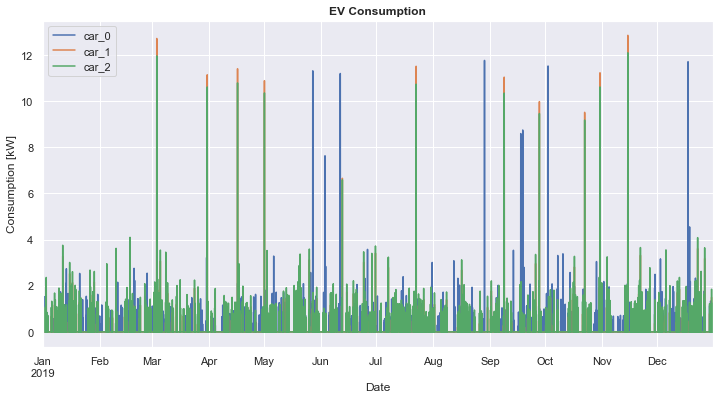

In [14]:
data_car_kw = pd.DataFrame()

for i, path in enumerate(paths):
    pickle_off = gzip.open(path, "rb")
    data = pickle.load(pickle_off)
    pickle_off.close()
    data_car_kw[f"car_{i}"] = data["profile"]["consumption"][:24*4*366]

START = "2019-01-01 00:00:00"
END = "2019-12-30 23:45:00"
dti = pd.date_range(start=START, end=END, freq="15T")
steps = len(dti)
data_car_kw = data_car_kw.head(steps)
data_car_kw["Date"] = dti
data_car_kw.set_index("Date", inplace=True)
data_car_w = data_car_kw*1000  # Car data needs to be in W

fig, ax = plt.subplots(figsize=(12, 6))
data_car_kw.plot(ax=ax)
plt.title("EV Consumption", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Consumption [kW]")
plt.show()


# Visualize Grid
Load the grid structure and preview of the topology


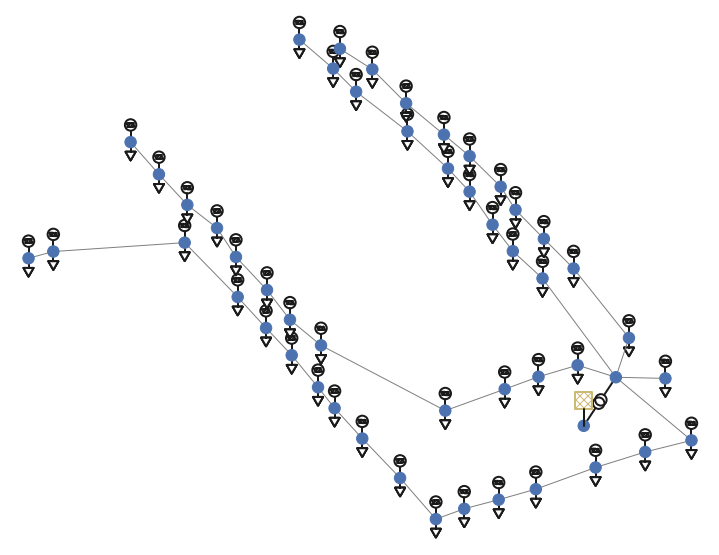

<AxesSubplot:>

In [15]:
# Load Grid
net = pp.from_json("data/processed/Grid_Model.json")
import pandapower.plotting as plot
plot.simple_plot(net, show_plot=True, plot_loads=True, plot_sgens=True)

# Household Data
Load the data of Household consumption and PV Consumption

Text(0.5, 0, '')

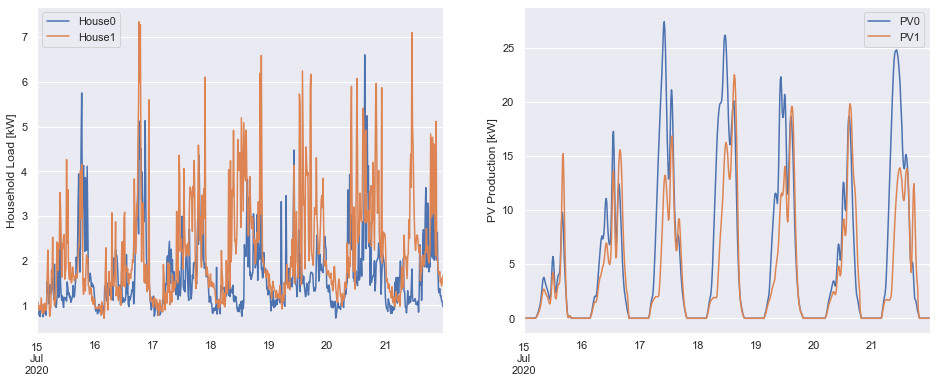

In [16]:

# Load Data
data_household_loads = pd.read_csv(
    "data/processed/Household_loads.csv", index_col="Time", parse_dates=True)
data_pv_production = pd.read_csv(
    "data/processed/pv_production.csv", index_col="Time", parse_dates=True)
week= 28
fig, axs=plt.subplots(1,2,figsize=(16,6))

#plot the households
ax= axs[0]
data_household_loads.iloc[week*24*4*7:(week+1)*24*4*7, 0:2].multiply(1/1000).plot(ax=ax)
ax.set_ylabel("Household Load [kW]")
ax.set_xlabel("")

#plot the PVs
ax= axs[1]
data_pv_production.iloc[week*24*4*7:(week+1)*24*4*7, 0:2].multiply(1/1000).plot(ax=ax)
ax.set_ylabel("PV Production [kW]")
ax.set_xlabel("")

Verify thet all data has the same length

In [17]:
# Get the number of rows for the minimum
n_data = min(
    data_household_loads.shape[0],
    data_pv_production.shape[0],
    data_car_w.shape[0])

The size of the baterry is considered as:

`1 MWh (total yearly consumption) == 1kWh (of battery size)`

A maximum discharge of the whole battery in 1h is then considered, then:

`1 kWh (battery size) == 1kW (Max Discharge)`

Since all is in Watts, it has to be mutliplied by 1000
For sizing purposes, the size of the battery is rounded to the 100s

In [18]:
battery_size = data_household_loads.sum()/4/1e6  # kWh
battery_size = round(battery_size, 1)
battery_size *= 1000
battery_power_lims = list(battery_size)

# This list has to be written in the net file. I prefer to do that here dynamically in case we find a better sizing method
for idx in net.storage.index:
    net.storage.at[idx,"min_p_mw"]= -battery_power_lims[idx]
    net.storage.at[idx,"max_p_mw"]= battery_power_lims[idx]


In [19]:
# Llists to save the results
import numpy as np
from tqdm import tqdm
import time
import correction_methods
# TQDM is an iterator that prints a progress bar... very useful

# Save voltage levels before and after the correction
res_max_vm_pu_after = []
res_min_vm_pu_after = []
res_max_vm_pu_before = []
res_min_vm_pu_before = []

# Save Line Load Levels before and after the correction
res_max_lines_before = []
res_min_lines_before = []
res_max_lines_after = []
res_min_lines_after = []

# Save Storage requirements
res_sto_dict = {}
res_sto_dict_Q = {}

# Save converge timing and number of iterations
res_timing = {}
res_iters = {}



In [20]:
# Test purposes: On 02.03 there are several issues with voltage during the day
# I use this day as sample
# for j in tqdm(range(n_data)): # uncomment here for whole year

for j in tqdm(range(5858, 5858+96)):
    for i in range(0, 49):
        net.load.at[i, "p_mw"] = data_household_loads[f"House{i}"][j]
        net.sgen.at[i, "p_mw"] = data_pv_production[f"PV{i}"][j]
        net.storage.at[i, "p_mw"] = 0
        net.storage.at[i, "q_mvar"] = 0

    # This part has to be manipulated with the real data of cars
    # TODO Henrik shall see how to fix this with real car data
    k = 49
    while k < 195:
        net.load.at[k, "p_mw"] = data_car_w["car_0"][j]
        net.load.at[k+1, "p_mw"] = data_car_w["car_1"][j]
        net.load.at[k+2, "p_mw"] = data_car_w["car_2"][j]
        k += 3

    # This is only to see if withouth corrections there are problems in the buses
    pp.runpp(net)

    res_max_vm_pu_before.append(max(net.res_bus["vm_pu"]))
    res_min_vm_pu_before.append(min(net.res_bus["vm_pu"]))

    res_max_lines_before.append(max(net.res_line["loading_percent"]))
    res_min_lines_before.append(min(net.res_line["loading_percent"]))

    if (min(net.res_bus["vm_pu"]) < 0.95 or max(net.res_bus["vm_pu"]) > 1.050):
        time_start = time.time()
        if METHOD == "VECTOR":
            net,iters = correction_methods.vector_method(net, restricted=False)
        if METHOD == "VECTOR_RESTRICTED":
            net,iters = correction_methods.vector_method(net, restricted=True)
        if METHOD == "VECTOR_IMPROVED":
            net,iters = correction_methods.vector_method_improved(net)
        if METHOD == "VECTOR_REACTIVE":
            net,iters = correction_methods.vector_method(
                net, restricted=True, reactive=True)
        if METHOD == "MAX_DEPEND":
            net,iters = correction_methods.max_dependencies_method(
                net,iterationSteps=1000)
    
        # Save the dict results in a dict of dicts
        storages_dict = {}
        storages_dict_Q = {}
        for sto_i in net.storage.index:
            if net.storage.at[sto_i, "p_mw"] != 0:
                storages_dict[sto_i] = round(net.storage.at[sto_i, "p_mw"], 2)
                if METHOD == "VECTOR_REACTIVE":
                    storages_dict_Q[sto_i] = round(
                        net.storage.at[sto_i, "q_mvar"], 2)

        res_sto_dict[j] = storages_dict
        res_sto_dict_Q[j] = storages_dict_Q
        res_timing[j] = round(time.time()-time_start, 3)
        res_iters[j] = iters


    res_max_vm_pu_after.append(max(net.res_bus["vm_pu"]))
    res_min_vm_pu_after.append(min(net.res_bus["vm_pu"]))

    res_max_lines_after.append(max(net.res_line["loading_percent"]))
    res_min_lines_after.append(min(net.res_line["loading_percent"]))



 76%|███████▌  | 73/96 [00:03<00:01, 20.73it/s]

Not converged after 100 iterations
Not converged after 100 iterations
Not converged after 100 iterations
Not converged after 100 iterations


In [ ]:
import json

res_json_dir = f"data/results/correction_{METHOD}.json"
with open(res_json_dir, 'w') as fp:
    json.dump(res_sto_dict, fp,  indent=4)

if METHOD == "VECTOR_REACTIVE":
    res_json_dir = f"data/results/Correction_{METHOD}_Q.json"
    with open(res_json_dir, 'w') as fp:
        json.dump(res_sto_dict_Q, fp,  indent=4)

res_time_json_dir = f"data/results/timing_{METHOD}.json"
with open(res_time_json_dir, 'w') as fp:
    json.dump(res_timing, fp,  indent=4)

res_iters_json_dir = f"data/results/iters_{METHOD}.json"
with open(res_iters_json_dir, 'w') as fp:
    json.dump(res_iters, fp,  indent=4)


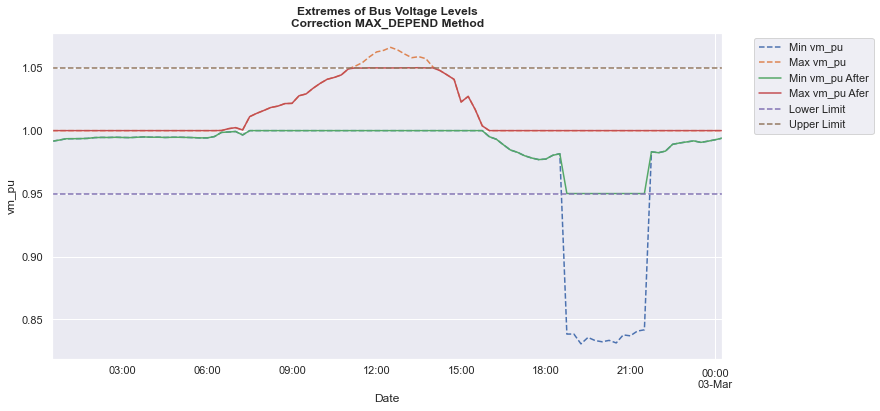

In [ ]:
from copy import deepcopy
res_bus = pd.DataFrame()
res_bus["Min vm_pu"] = res_min_vm_pu_before
res_bus["Max vm_pu"] = res_max_vm_pu_before
res_bus["Min vm_pu After"] = res_min_vm_pu_after
res_bus["Max vm_pu Afer"] = res_max_vm_pu_after


START = "2020-01-01 00:00:00"
END = "2020-12-30 23:45:00"
dti_res = pd.date_range(start=START, end=END, freq="15T")
res_bus["Date"] = dti_res[5858:5858+96]
# res["Date"]=dti_res
res_bus.set_index("Date", inplace=True)

res_bus.to_csv(f"data/results/buses_extremes_{METHOD}.csv")
res_plot = deepcopy(res_bus)
res_plot["Lower Limit"] = [0.95]*len(res_min_vm_pu_before)
res_plot["Upper Limit"] = [1.05]*len(res_max_vm_pu_before)

fig, ax = plt.subplots(figsize=(12, 6))
res_plot.plot(style=['--', '--', '-', '-', '--', '--'], ax=ax)

plt.title(
    f"Extremes of Bus Voltage Levels\nCorrection {METHOD} Method", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("vm_pu")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.savefig(
    f"data/results/Buses_Extremes_Year_{METHOD}.jpg", bbox_inches='tight')


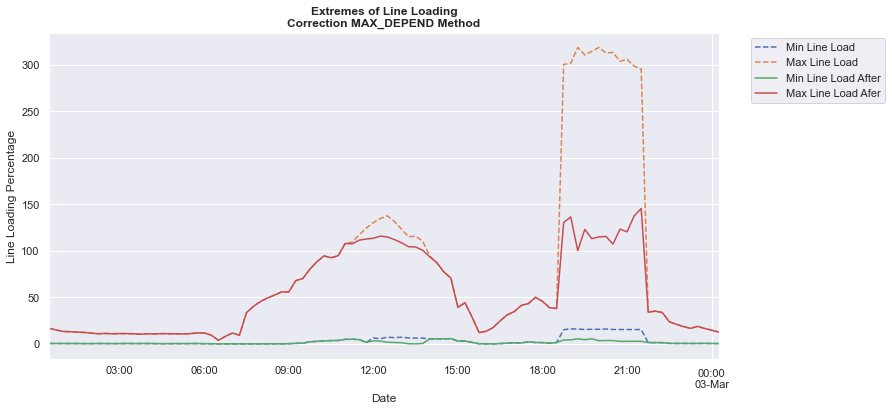

In [ ]:
res_lines = pd.DataFrame()
res_lines["Min Line Load"] = res_min_lines_before
res_lines["Max Line Load"] = res_max_lines_before
res_lines["Min Line Load After"] = res_min_lines_after
res_lines["Max Line Load Afer"] = res_max_lines_after


START = "2020-01-01 00:00:00"
END = "2020-12-30 23:45:00"
dti_res = pd.date_range(start=START, end=END, freq="15T")
res_lines["Date"] = dti_res[5858:5858+96]
# res["Date"]=dti_res
res_lines.set_index("Date", inplace=True)

res_lines.to_csv(f"data/results/lines_extremes_{METHOD}.csv")
res_plot = deepcopy(res_lines)

fig, ax = plt.subplots(figsize=(12, 6))
res_plot.plot(style=['--', '--', '-', '-', '--', '--'], ax=ax)

plt.title(
    f"Extremes of Line Loading\nCorrection {METHOD} Method", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Line Loading Percentage")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.savefig(
    f"data/results/Lines_Extremes_Year_{METHOD}.jpg", bbox_inches='tight')


In [ ]:
week = 28
res_plot_week = deepcopy(res_bus[24*4*7*week:24*4*7*(week+1)])
res_plot_week["Lower Limit"] = [0.95]*24*4*7
res_plot_week["Upper Limit"] = [1.05]*24*4*7

fig, ax = plt.subplots(figsize=(12, 6))
res_plot_week.plot(style=['--', '--', '-', '-', '--', '--'], ax=ax)
plt.title(
    f"Extremes of Bus Voltage Levels\nCorrection {METHOD} Method", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("vm_pu")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.savefig(
    f"data/results/Buses_Extremes_Week_{week}_{METHOD}.jpg", bbox_inches='tight')

plt.close()
